In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_from_disk
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import torch.optim as optim

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)

split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

test_x = np.array(test_dataset['embedding'])
test_y = np.array(test_dataset['labels'])

from torch.utils.data import Dataset, DataLoader, Subset

class EmbeddingSequenceDataset(Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingSequenceDataset(train_dataset)
test_ds = EmbeddingSequenceDataset(test_dataset)

def get_loader(dataset, batch_size=32, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

test_loader = get_loader(test_ds, batch_size=32, shuffle=False)
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        out, (h, c) = self.lstm(x.unsqueeze(1))  # Add an extra dimension to the input tensor
        h_last = h[-1]  
        h_last = self.dropout(h_last)
        logits = self.fc(h_last)
        return logits

sample_emb, _ = train_ds[0]
input_dim = sample_emb.shape[0]  # Change to shape[0] to get the correct input dimension
hidden_dim = 128
num_classes = len(np.unique(test_y))  


def train_and_evaluate(model, train_loader, test_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")
    
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    return test_acc, all_preds, all_labels

/tmp/ipykernel_52147/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)



使用訓練資料數量: 20 筆
開始訓練...


/tmp/ipykernel_52147/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_52147/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)
/tmp/ipykernel_52147/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


Epoch 1: Train Loss=1.1117, Train Acc=0.2500
Epoch 2: Train Loss=0.8737, Train Acc=0.8500
Epoch 3: Train Loss=0.7300, Train Acc=0.9000
Epoch 4: Train Loss=0.6010, Train Acc=0.9500
Epoch 5: Train Loss=0.4645, Train Acc=0.9000
Epoch 6: Train Loss=0.4046, Train Acc=0.9000
Epoch 7: Train Loss=0.3735, Train Acc=0.9500
Epoch 8: Train Loss=0.3264, Train Acc=0.9500
Epoch 9: Train Loss=0.2550, Train Acc=0.9500
Epoch 10: Train Loss=0.2388, Train Acc=0.9500
Test Loss=0.3600, Test Acc=0.8796
Test Accuracy for sample size 20: 0.8796
Classification Report:
               precision    recall  f1-score   support

contradiction       0.83      0.87      0.85       271
   entailment       0.81      0.95      0.87       564
      neutral       0.94      0.85      0.89      1133

     accuracy                           0.88      1968
    macro avg       0.86      0.89      0.87      1968
 weighted avg       0.89      0.88      0.88      1968

Confusion Matrix:
[[237   3  31]
 [  1 533  30]
 [ 48 124 961]]

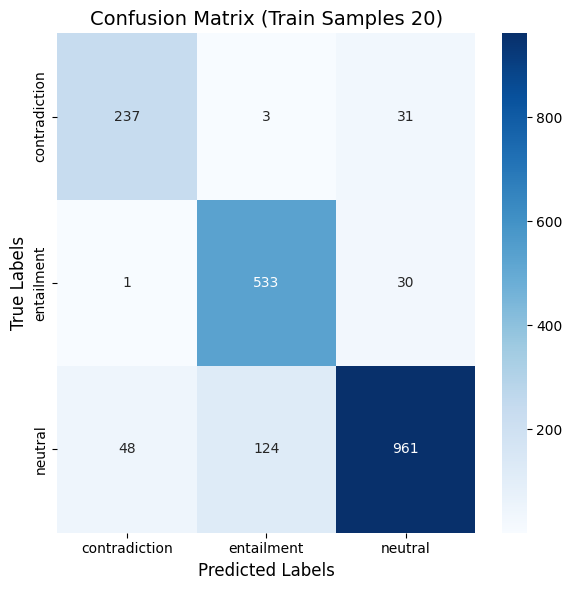


使用訓練資料數量: 50 筆
開始訓練...
Epoch 1: Train Loss=1.0247, Train Acc=0.4400
Epoch 2: Train Loss=0.7003, Train Acc=0.8600
Epoch 3: Train Loss=0.5412, Train Acc=0.8800
Epoch 4: Train Loss=0.4313, Train Acc=0.9000
Epoch 5: Train Loss=0.3568, Train Acc=0.9000
Epoch 6: Train Loss=0.3234, Train Acc=0.9000
Epoch 7: Train Loss=0.2613, Train Acc=0.9200
Epoch 8: Train Loss=0.2551, Train Acc=0.9200
Epoch 9: Train Loss=0.2499, Train Acc=0.9000
Epoch 10: Train Loss=0.2006, Train Acc=0.9400
Test Loss=0.3340, Test Acc=0.8841
Test Accuracy for sample size 50: 0.8841
Classification Report:
               precision    recall  f1-score   support

contradiction       0.85      0.88      0.86       271
   entailment       0.81      0.94      0.87       564
      neutral       0.94      0.86      0.90      1133

     accuracy                           0.88      1968
    macro avg       0.87      0.89      0.88      1968
 weighted avg       0.89      0.88      0.88      1968

Confusion Matrix:
[[238   2  31]
 [  1 

/tmp/ipykernel_52147/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_52147/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)
/tmp/ipykernel_52147/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


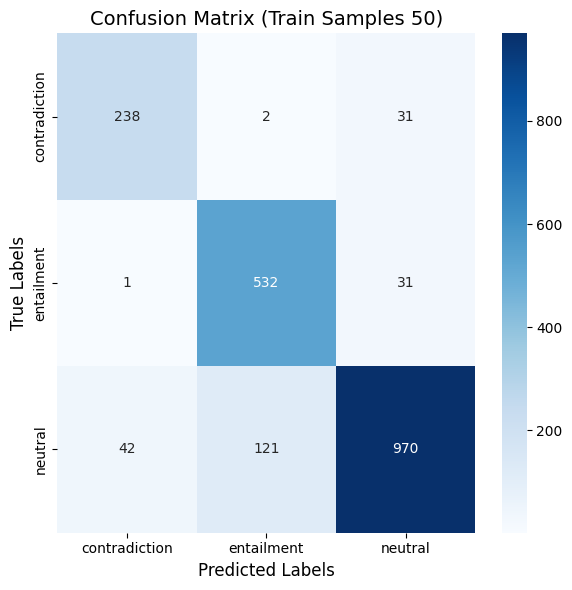


使用訓練資料數量: 70 筆
開始訓練...
Epoch 1: Train Loss=1.0870, Train Acc=0.3714
Epoch 2: Train Loss=0.6988, Train Acc=0.8857
Epoch 3: Train Loss=0.5185, Train Acc=0.9000
Epoch 4: Train Loss=0.4034, Train Acc=0.9143
Epoch 5: Train Loss=0.3561, Train Acc=0.9143
Epoch 6: Train Loss=0.3017, Train Acc=0.9286
Epoch 7: Train Loss=0.3220, Train Acc=0.9000
Epoch 8: Train Loss=0.2710, Train Acc=0.9429
Epoch 9: Train Loss=0.2361, Train Acc=0.9429
Epoch 10: Train Loss=0.2512, Train Acc=0.9286
Test Loss=0.3145, Test Acc=0.8811
Test Accuracy for sample size 70: 0.8811
Classification Report:
               precision    recall  f1-score   support

contradiction       0.77      0.90      0.83       271
   entailment       0.84      0.93      0.88       564
      neutral       0.94      0.85      0.89      1133

     accuracy                           0.88      1968
    macro avg       0.85      0.89      0.87      1968
 weighted avg       0.89      0.88      0.88      1968

Confusion Matrix:
[[245   2  24]
 [  1 

/tmp/ipykernel_52147/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_52147/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)
/tmp/ipykernel_52147/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


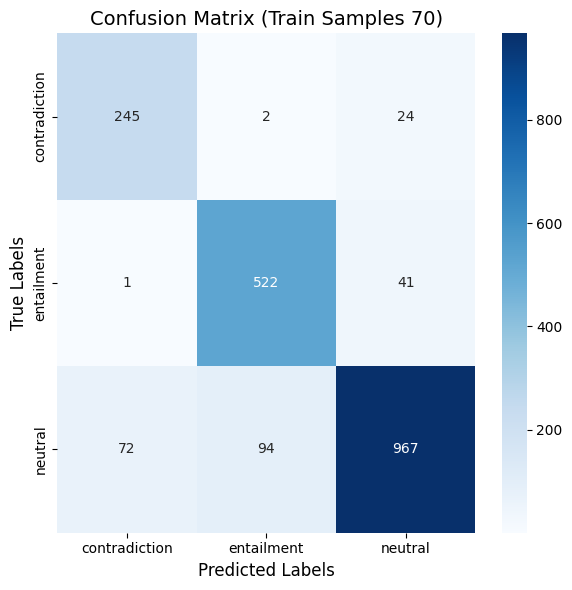


使用訓練資料數量: 100 筆
開始訓練...
Epoch 1: Train Loss=0.8968, Train Acc=0.7200
Epoch 2: Train Loss=0.5352, Train Acc=0.8700
Epoch 3: Train Loss=0.3945, Train Acc=0.9000
Epoch 4: Train Loss=0.3397, Train Acc=0.9000
Epoch 5: Train Loss=0.2832, Train Acc=0.9300
Epoch 6: Train Loss=0.2837, Train Acc=0.9000
Epoch 7: Train Loss=0.2554, Train Acc=0.9200
Epoch 8: Train Loss=0.2516, Train Acc=0.9200
Epoch 9: Train Loss=0.2640, Train Acc=0.9200
Epoch 10: Train Loss=0.2437, Train Acc=0.9300
Test Loss=0.2761, Test Acc=0.8974
Test Accuracy for sample size 100: 0.8974
Classification Report:


/tmp/ipykernel_52147/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_52147/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)
/tmp/ipykernel_52147/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


               precision    recall  f1-score   support

contradiction       0.88      0.87      0.87       271
   entailment       0.86      0.90      0.88       564
      neutral       0.92      0.90      0.91      1133

     accuracy                           0.90      1968
    macro avg       0.89      0.89      0.89      1968
 weighted avg       0.90      0.90      0.90      1968

Confusion Matrix:
[[ 235    1   35]
 [   0  510   54]
 [  32   80 1021]]


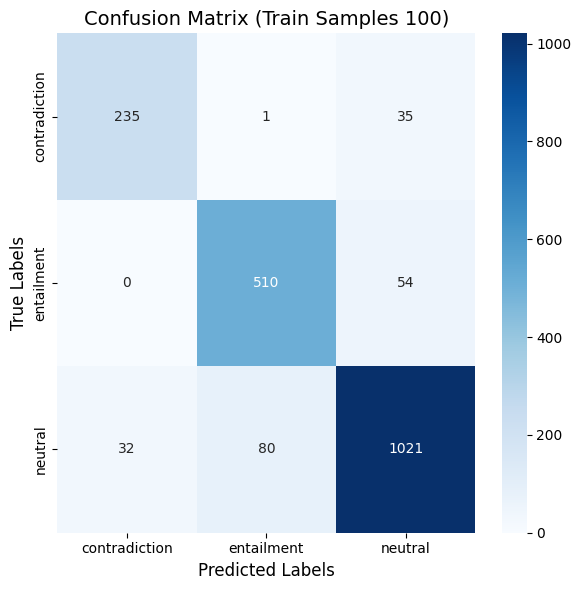


使用訓練資料數量: 300 筆
開始訓練...
Epoch 1: Train Loss=0.6419, Train Acc=0.8133
Epoch 2: Train Loss=0.3103, Train Acc=0.9100
Epoch 3: Train Loss=0.2725, Train Acc=0.9167
Epoch 4: Train Loss=0.2447, Train Acc=0.9167
Epoch 5: Train Loss=0.2348, Train Acc=0.9333
Epoch 6: Train Loss=0.2417, Train Acc=0.9267
Epoch 7: Train Loss=0.2244, Train Acc=0.9333


/tmp/ipykernel_52147/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_52147/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


Epoch 8: Train Loss=0.2165, Train Acc=0.9333
Epoch 9: Train Loss=0.2069, Train Acc=0.9300
Epoch 10: Train Loss=0.2087, Train Acc=0.9333
Test Loss=0.2594, Test Acc=0.9080
Test Accuracy for sample size 300: 0.9080
Classification Report:
               precision    recall  f1-score   support

contradiction       0.91      0.86      0.89       271
   entailment       0.93      0.85      0.89       564
      neutral       0.90      0.95      0.92      1133

     accuracy                           0.91      1968
    macro avg       0.91      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix:
[[ 234    0   37]
 [   0  481   83]
 [  22   39 1072]]


/tmp/ipykernel_52147/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


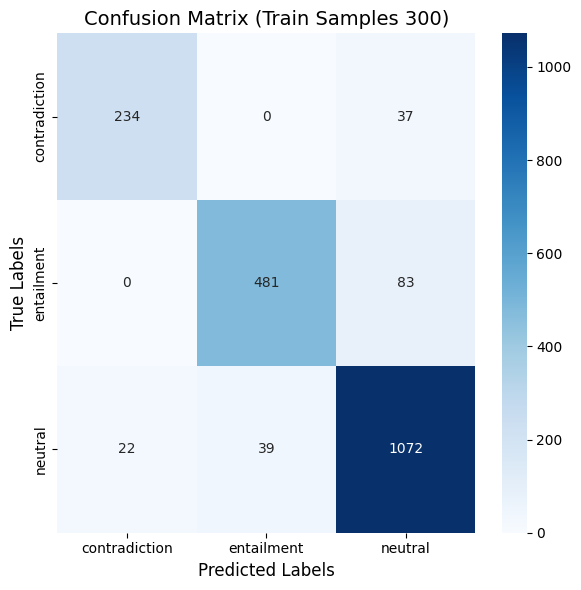

/tmp/ipykernel_52147/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_52147/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)



使用訓練資料數量: 1000 筆
開始訓練...
Epoch 1: Train Loss=0.3832, Train Acc=0.8810
Epoch 2: Train Loss=0.2614, Train Acc=0.9180
Epoch 3: Train Loss=0.2465, Train Acc=0.9230
Epoch 4: Train Loss=0.2352, Train Acc=0.9240
Epoch 5: Train Loss=0.2413, Train Acc=0.9180
Epoch 6: Train Loss=0.2361, Train Acc=0.9230
Epoch 7: Train Loss=0.2235, Train Acc=0.9260
Epoch 8: Train Loss=0.2200, Train Acc=0.9250
Epoch 9: Train Loss=0.2191, Train Acc=0.9200
Epoch 10: Train Loss=0.2022, Train Acc=0.9350
Test Loss=0.2529, Test Acc=0.9075
Test Accuracy for sample size 1000: 0.9075
Classification Report:
               precision    recall  f1-score   support

contradiction       0.91      0.86      0.88       271
   entailment       0.92      0.86      0.89       564
      neutral       0.90      0.94      0.92      1133

     accuracy                           0.91      1968
    macro avg       0.91      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix:
[[ 233    0   38]

/tmp/ipykernel_52147/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


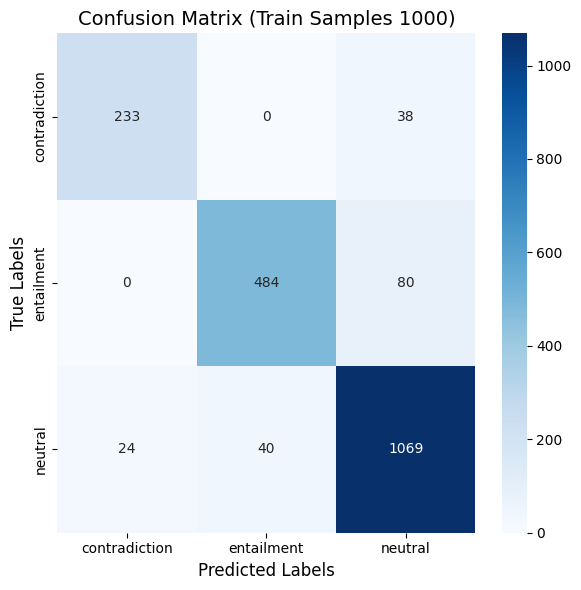

/tmp/ipykernel_52147/222405892.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_52147/222405892.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)



使用訓練資料數量: 7872 筆
開始訓練...
Epoch 1: Train Loss=0.2721, Train Acc=0.9035
Epoch 2: Train Loss=0.2440, Train Acc=0.9090
Epoch 3: Train Loss=0.2414, Train Acc=0.9122
Epoch 4: Train Loss=0.2368, Train Acc=0.9122
Epoch 5: Train Loss=0.2378, Train Acc=0.9107
Epoch 6: Train Loss=0.2309, Train Acc=0.9125
Epoch 7: Train Loss=0.2326, Train Acc=0.9118
Epoch 8: Train Loss=0.2301, Train Acc=0.9132
Epoch 9: Train Loss=0.2265, Train Acc=0.9154
Epoch 10: Train Loss=0.2279, Train Acc=0.9130
Test Loss=0.2320, Test Acc=0.9121
Test Accuracy for sample size 7872: 0.9121
Classification Report:
               precision    recall  f1-score   support

contradiction       0.95      0.84      0.89       271
   entailment       0.90      0.88      0.89       564
      neutral       0.91      0.94      0.93      1133

     accuracy                           0.91      1968
    macro avg       0.92      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix:
[[ 228    0   43]

/tmp/ipykernel_52147/222405892.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings, labels = embeddings.to(device), torch.tensor(labels, dtype=torch.long).to(device)


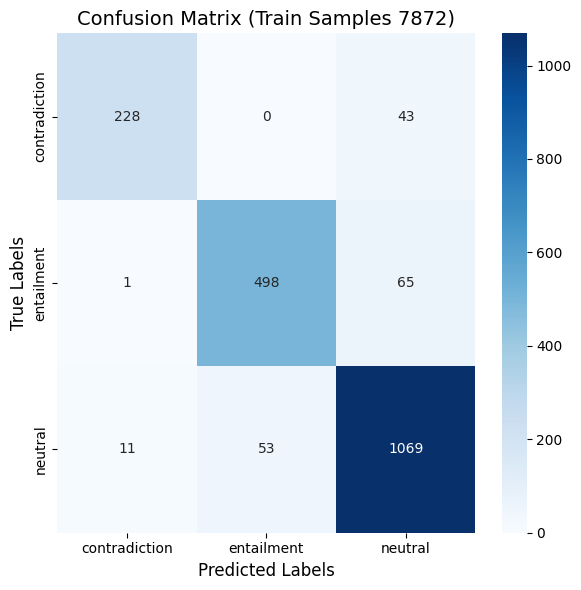

In [3]:
from torch.utils.data import Subset
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_ds)]
num_epochs = 10
learning_rate = 0.001
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

accuracy_list = {}

for size in sample_sizes:
    print(f"\n使用訓練資料數量: {size} 筆")
    train_subset = Subset(train_ds, range(size))
    train_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)
    
    model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    model.to(device)
    
    print("開始訓練...")
    test_acc, all_preds, all_labels = train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate, device)
    print(f"Test Accuracy for sample size {size}: {test_acc:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["contradiction", "entailment", "neutral"]))
    
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues,
                xticklabels=["contradiction", "entailment", "neutral"],
                yticklabels=["contradiction", "entailment", "neutral"])
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.title(f"Confusion Matrix (Train Samples {size})", fontsize=14)
    plt.tight_layout()
    plt.show()
    accuracy_list.update({size: test_acc})
    

In [4]:
print(tabulate([[size, arr] for size, arr in accuracy_list.items()], headers=["Train Size", "Accuracy"], tablefmt="fancy_grid"))

╒══════════════╤════════════╕
│   Train Size │   Accuracy │
╞══════════════╪════════════╡
│           20 │   0.879573 │
├──────────────┼────────────┤
│           50 │   0.884146 │
├──────────────┼────────────┤
│           70 │   0.881098 │
├──────────────┼────────────┤
│          100 │   0.897358 │
├──────────────┼────────────┤
│          300 │   0.908028 │
├──────────────┼────────────┤
│         1000 │   0.90752  │
├──────────────┼────────────┤
│         7872 │   0.912093 │
╘══════════════╧════════════╛
